<a href="https://colab.research.google.com/github/gabrielfea/previsaoacoes/blob/main/Projeto_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **GABRIEL VINICIUS BOIN FREITAS</BR>
LEONARDO CARDOSO SANTOS**

#Inicio - Análise descritiva da série temporal

 <b>1. Seleção de Dados: • Os alunos devem escolher um conjunto de dados com características temporais relevantes para o problema proposto. Exemplos incluem séries temporais financeiras, dados meteorológicos, registros de vendas, entre outros.


In [ ]:
!pip install pmdarima
!pip install tensorflow
!pip install keras
!pip install numpy pandas statsmodels deap
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import metrics
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn import preprocessing

from pmdarima import auto_arima

import yfinance as yf
yf.pdr_override()

from pandas_datareader import data as pdr

import datetime
from datetime import date
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.offline as py
from plotly.subplots import make_subplots

from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout

tf.random.set_seed(123)
np.random.seed(123)
import random
random.seed(123)

In [ ]:
def get(tickers,startdate,enddate):
   def data(ticker):
       return(pdr.get_data_yahoo(ticker, start=startdate,end=enddate))
   datas = map(data,tickers)
   all_data = pd.concat(datas, keys=tickers, names=['Ticker', 'Date'])
   return all_data

In [ ]:
tickers = ["MGLU3.SA"]
startdate = date(2020,1,1)
enddate = date.today()

data = get(tickers,startdate,enddate)

asset = tickers[0]
data.loc[asset].tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-30,1.43,1.45,1.34,1.36,1.36,104966200
2024-05-02,1.40,1.48,1.39,1.46,1.46,129948300
2024-05-03,1.50,1.58,1.50,1.57,1.57,173467500
2024-05-06,1.58,1.61,1.54,1.57,1.57,97166300
2024-05-07,1.58,1.65,1.57,1.61,1.61,83097400


Escolhida série de preços das ações do Magazine Luiza S.A. na bolsa de valores brasileira, B3.

<b>2. Pré-processamento de Dados: • Realizar a limpeza e preparação dos dados, incluindo tratamento de valores ausentes, normalização e codificação de variáveis categóricas, se necessário.


Analisando apenas a tendência.

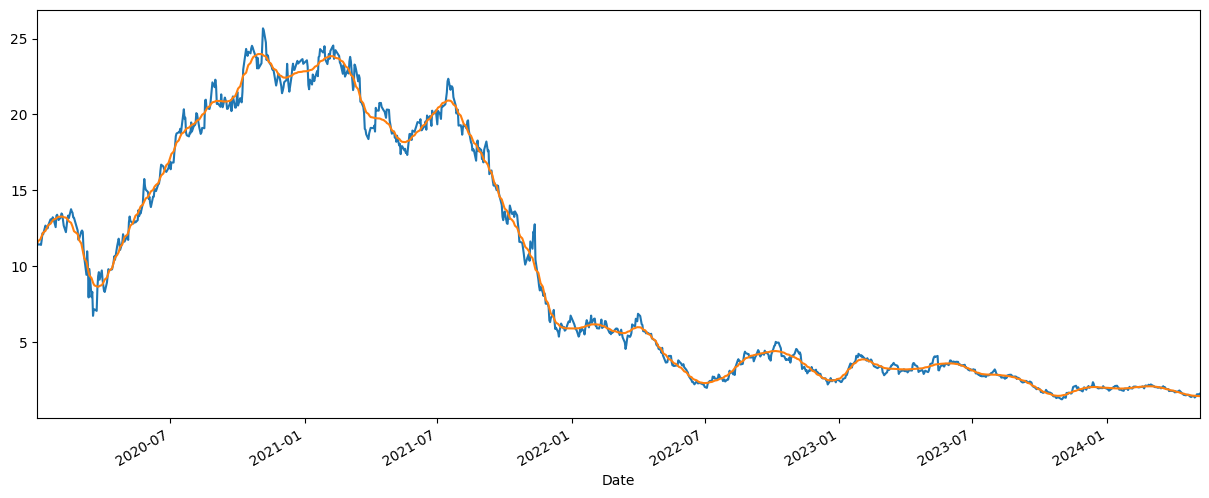

In [ ]:
df = data.loc[asset,["Close","High","Low"]]
df_cycle,df_trend = hpfilter(df["Close"], lamb=1600)
df["Close"].plot(figsize=(15,6)).autoscale(axis='x',tight=True)
df_trend.plot(figsize=(15,6)).autoscale(axis='x',tight=True)
df["Trend"] = df_trend
df_close = df["Close"]

Analisando se seria interessante utilizar outra séria de dados em apoio à previsão da tendência, além da própria tendência passada.

<Axes: >

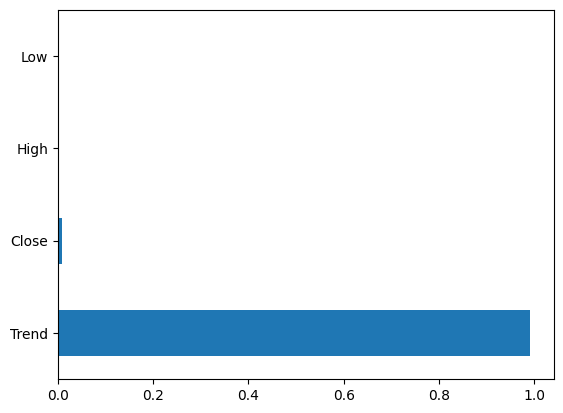

In [ ]:
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot

model = XGBRegressor()
model.fit(df[["High","Low",'Close','Trend']],df['Trend'])

(pd.Series(model.feature_importances_, index=df[["High","Low",'Close','Trend']].columns)
   .nlargest(7)
   .plot(kind='barh'))

Olhando os dados sem a tendência.

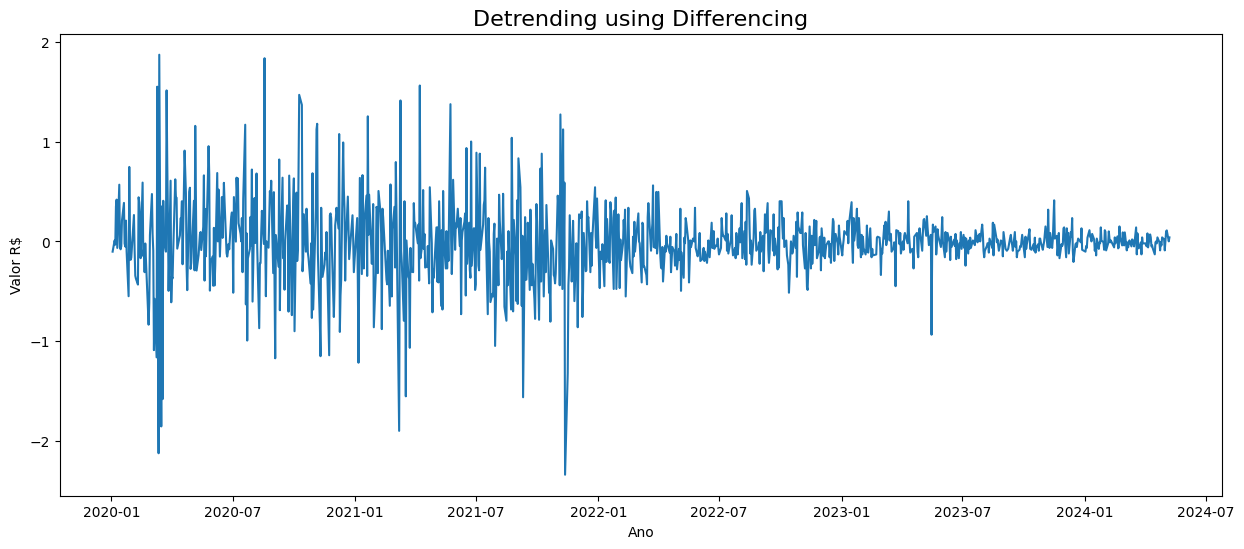

In [ ]:
diff = df["Close"].diff()
plt.figure(figsize=(15,6))
plt.plot(diff)
plt.title('Detrending using Differencing', fontsize=16)
plt.xlabel('Ano')
plt.ylabel('Valor R$')
plt.show()

Procurando por sasonalidade.

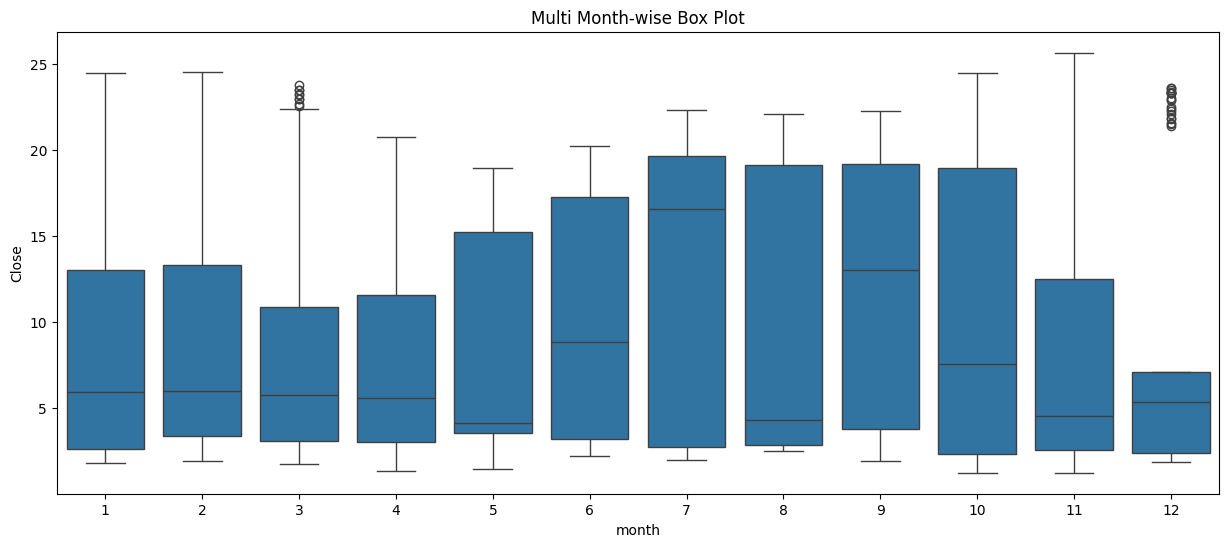

In [ ]:
df2 = pd.DataFrame(df["Close"])
df2['Date'] = pd.to_datetime(df2.index)
df2['month'] = df2['Date'].dt.strftime('%b')
df2['year'] = [d.year for d in df2.Date]
df2['month'] = [d.month for d in df2.Date]
years = df2['year'].unique()
plt.figure(figsize=(15,6))
sns.boxplot(x='month', y="Close", data=df2).set_title("Multi Month-wise Box Plot")
plt.show()

Analisando a autocorrelação nos dados.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

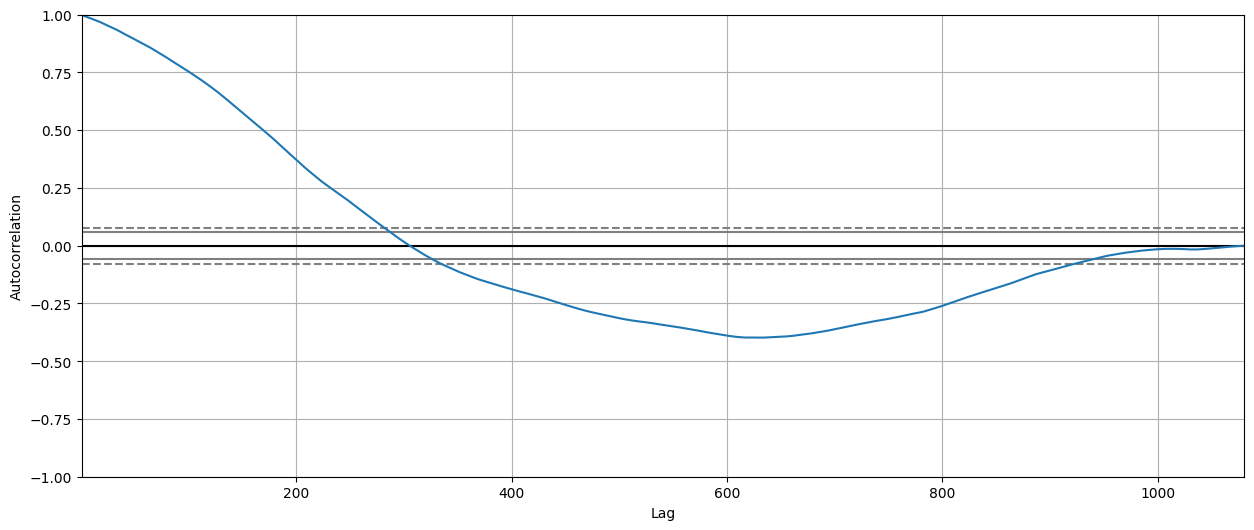

In [ ]:
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':100})
autocorrelation_plot(df["Close"].tolist())

Tirando a sasonalidade.

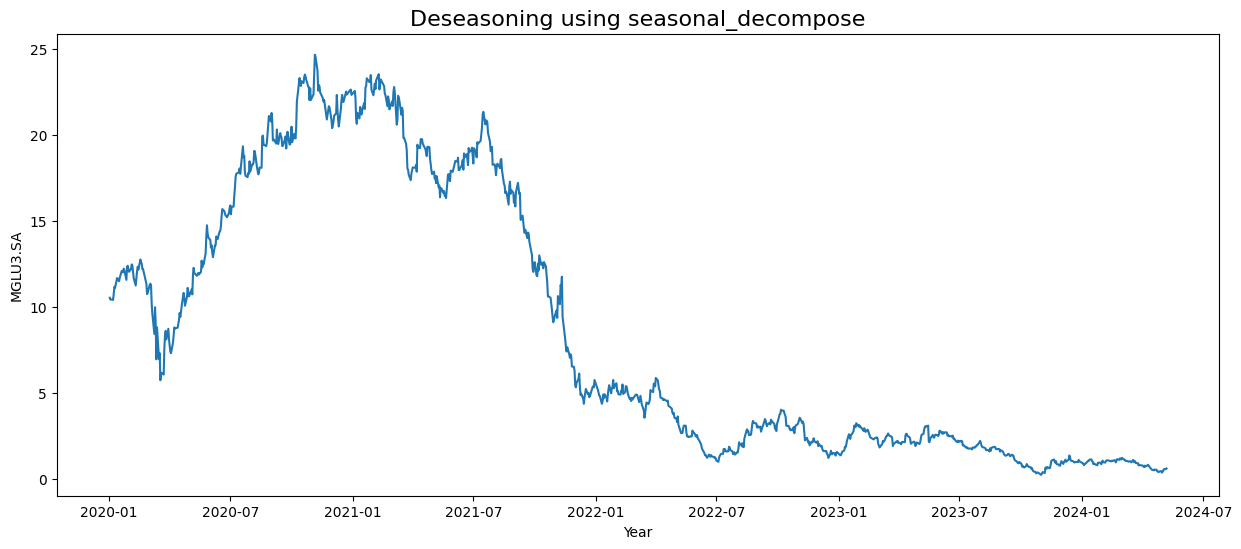

In [ ]:
result_mul = seasonal_decompose(df["Close"], model='multiplicative', period=12, extrapolate_trend='freq')
deseason = df["Close"] - result_mul.seasonal
plt.figure(figsize=(15,6))
plt.plot(deseason)
plt.title('Deseasoning using seasonal_decompose', fontsize=16)
plt.xlabel('Year')
plt.ylabel(f'{asset}')
plt.show()

Tirando variações cíclicas.

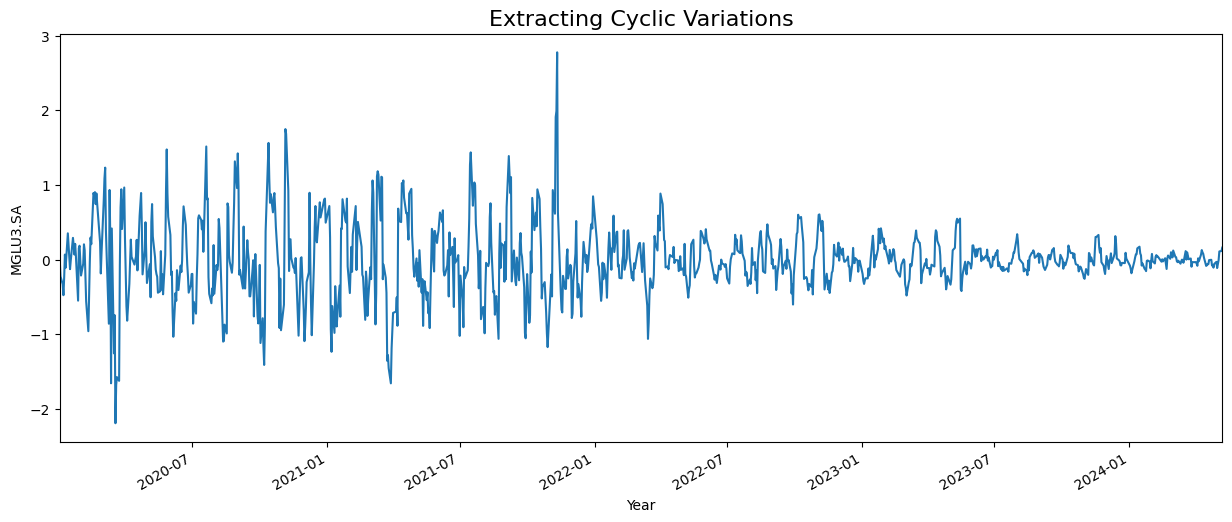

In [ ]:
df_cycle, df_trend = hpfilter(df["Close"], lamb=1600)
df_cycle.plot(figsize=(15,6)).autoscale(axis='x',tight=True)
plt.title('Extracting Cyclic Variations', fontsize=16)
plt.xlabel('Year')
plt.ylabel(f'{asset}')
plt.show()

Análise decomposta multiplicativa da série.

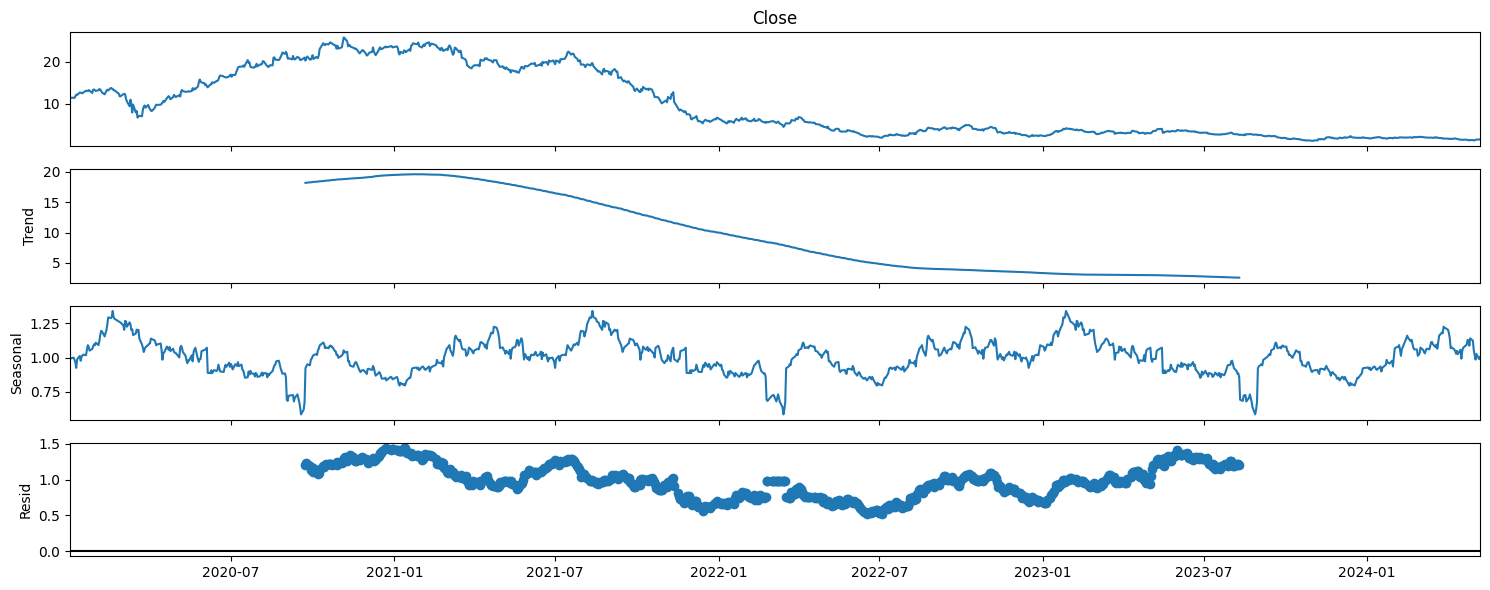

In [ ]:
result = seasonal_decompose(df["Close"], period=365, model='mul')
result.plot();

Analisando qual a distribuição dos valores da ação ao longo do tempo.

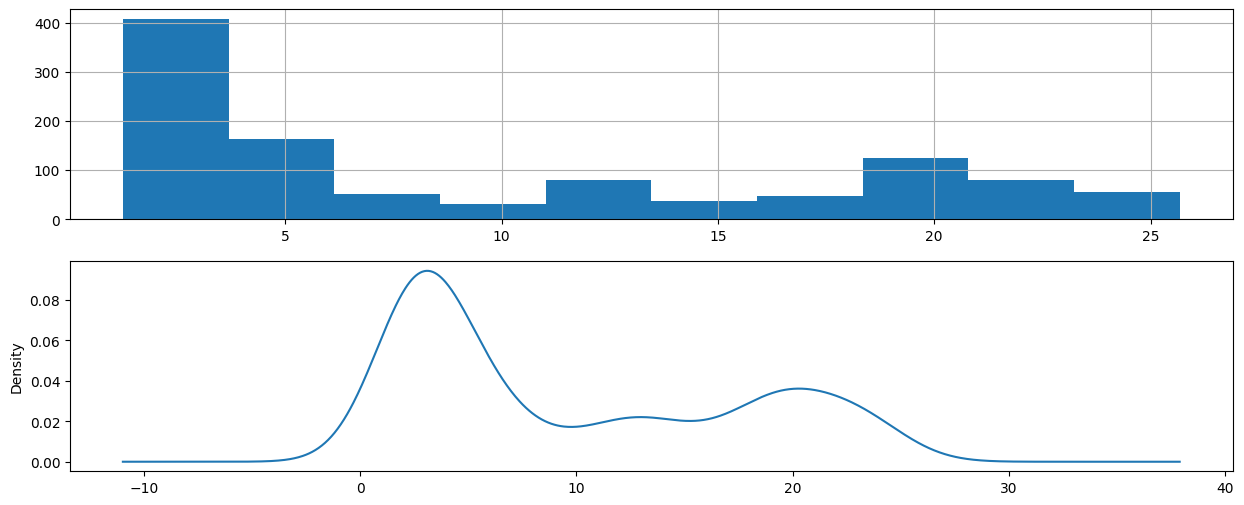

In [ ]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
df["Close"].hist()
plt.subplot(212)
df["Close"].plot(kind='kde')
plt.show()

Criando função para avaliação dos modelos a serem criados.

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    MSE = metrics.mean_squared_error(y_true, y_pred)
    MAE = metrics.mean_absolute_error(y_true, y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    R2 = metrics.r2_score(y_true, y_pred)
    print('Evaluation metric results:-')
    print(f'MSE is : {MSE}')
    print(f'MAE is : {MAE}')
    print(f'RMSE is : {RMSE}')
    print(f'MAPE is : {MAPE}')
    print(f'R2 is : {R2}',end='\n\n')
    return  {"MSE":[MSE],"MAE":[MAE],"RMSE":[RMSE],"MAPE":[MAPE],"R2":[R2]}

In [ ]:
resultados = pd.DataFrame(columns=["MSE","MAE","RMSE","MAPE","R2"])

Criando função com o teste de Dickey Fuller para verificar se a série é estacionária ou não.

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df["Close"],'Close')

Results of Dickey-Fuller Test for column: Close
Test Statistic                   -0.444392
p-value                           0.902419
No Lags Used                      1.000000
Number of Observations Used    1078.000000
Critical Value (1%)              -3.436431
Critical Value (5%)              -2.864225
Critical Value (10%)             -2.568200
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


A série não é estacionária.

  <b>3. Divisão de Dados: • Separar o conjunto de dados em conjuntos de treinamento, teste e validação, garantindo a representatividade temporal em cada conjunto.
  <br>4. Desenvolvimento de Modelos: • Implementar três modelos preditivos: • Um modelo de escolha livre, que pode incluir regressão linear, árvores de decisão, ou qualquer outra técnica de modelagem preditiva. • Um modelo baseado em computação evolucionária • Um modelo baseado em redes neurais, utilizando uma arquitetura adequada para lidar com dados temporais.
  <br>5. Treinamento e Validação: • Treinar os modelos nos dados de treinamento e validar o desempenho utilizando os dados de validação. • Ajustar os hiper parâmetros dos modelos, se necessário, para melhorar o desempenho. 6. Avaliação de Desempenho: • Comparar o desempenho dos dois modelos utilizando métricas apropriadas, como erro médio absoluto (MAE), erro quadrático médio (MSE) e coeficiente de determinação (R²).


#Primeiro modelo - Auto - ARIMA:

Separando dados de treino, validação e teste.

In [ ]:
X = df["Close"]
train, val, test = X[0:-90], X[-90:-30], X[-30:]

Utilizando o auto-arima para identificar a melhor modelagem a ser usada com Arima.

In [ ]:
stepwise_model = auto_arima(train,start_p=1, start_q=1,
    max_p=100, max_q=100, seasonal=True,
    d=None, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1019.943, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1019.767, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1018.298, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1018.403, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1018.331, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1020.069, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1021.942, Time=1.68 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1016.932, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1018.684, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1018.561, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1017.039, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1020.559, Time=0.51 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 6.040 seconds


Modelo criado:

In [ ]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  990
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -506.466
Date:                Wed, 08 May 2024   AIC                           1016.932
Time:                        17:03:31   BIC                           1026.725
Sample:                             0   HQIC                          1020.656
                                - 990                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0586      0.019     -3.159      0.002      -0.095      -0.022
sigma2         0.1630      0.004     41.862      0.000       0.155       0.171
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1074.65
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Gerando previsões para comparar com a validação e em seguida com a base teste.

In [ ]:
forecast1,conf_int1 = stepwise_model.predict(n_periods=60,return_conf_int=True)
forecast1 = pd.DataFrame(forecast1,columns=['close_pred'])

In [ ]:
df_conf1 = pd.DataFrame(conf_int1,columns= ['Upper_bound','Lower_bound'])
df_conf1["new_index"] = df.index[-90:-30]
df_conf1 = df_conf1.set_index("new_index")

Avaliação da previsão em relação a base de validação.

In [ ]:
timeseries_evaluation_metrics_func(val, forecast1)

Evaluation metric results:-
MSE is : 0.010607713259458251
MAE is : 0.085461682579874
RMSE is : 0.1029937534972789
MAPE is : 4.234445972626502
R2 is : -0.09410281436280643



{'MSE': [0.010607713259458251],
 'MAE': [0.085461682579874],
 'RMSE': [0.1029937534972789],
 'MAPE': [4.234445972626502],
 'R2': [-0.09410281436280643]}

In [ ]:
forecast2,conf_int2 = stepwise_model.predict(n_periods=30,return_conf_int=True)
forecast2 = pd.DataFrame(forecast2,columns=['close_pred'])

In [ ]:
df_conf2 = pd.DataFrame(conf_int2,columns= ['Upper_bound','Lower_bound'])
df_conf2["new_index"] = df.index[-30:]
df_conf2 = df_conf2.set_index("new_index")

Avaliação da previsão em relação à base teste.

In [ ]:
resultados = pd.concat([resultados,pd.DataFrame(data=timeseries_evaluation_metrics_func(test, forecast2))],axis=0)

Evaluation metric results:-
MSE is : 0.15368944251529093
MAE is : 0.36099563583100974
RMSE is : 0.39203245084468574
MAPE is : 23.379816248523316
R2 is : -5.576387494937645



In [ ]:
forecast1["new_index"] = df.index[-90:-30]
forecast1 = forecast1.set_index("new_index")

forecast2["new_index"] = df.index[-30:]
forecast2 = forecast2.set_index("new_index")

Plotando as previsões e seus intervalos de onfiança e comparando com o que ocorreu de fato.

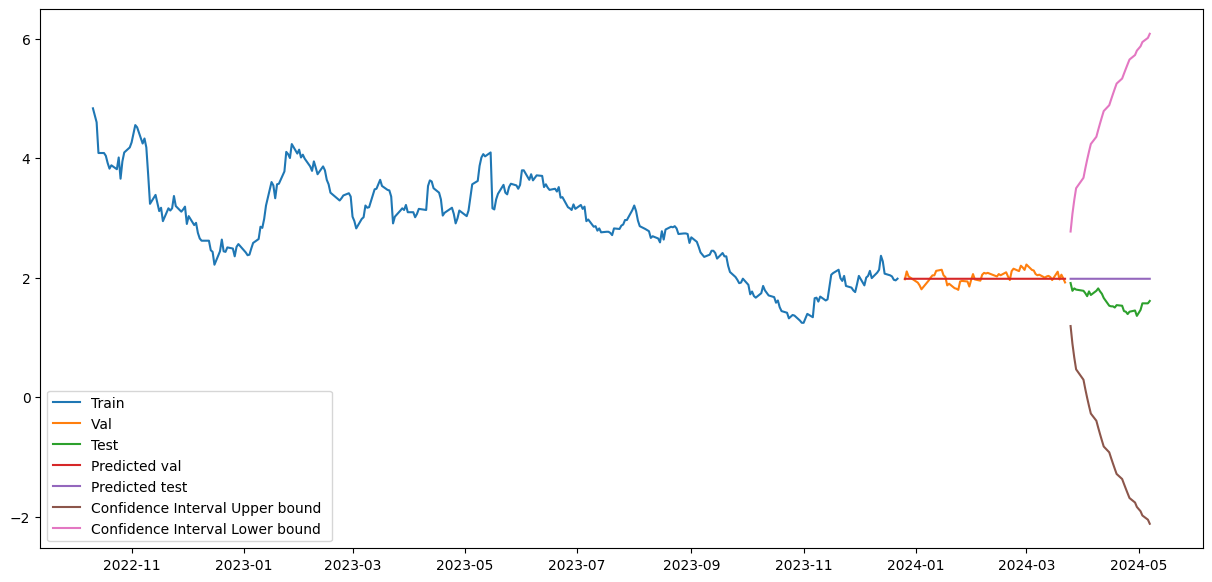

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,7]
plt.plot( train[-300:], label='Train ')
plt.plot( val, label='Val ')
plt.plot(test, label='Test ')
plt.plot(forecast1, label='Predicted val')
plt.plot(forecast2, label='Predicted test')
#plt.plot(df_conf1['Upper_bound'], label='Confidence Interval Upper bound ')
#plt.plot(df_conf1['Lower_bound'], label='Confidence Interval Lower bound ')
plt.plot(df_conf2['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf2['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

#Segundo modelo - LSTM

Criando função para preparar os dados para envio ao Tensorflow.

In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

Guardando dados de teste.

In [ ]:
h = 90
predition_X = df.tail(h)
uni_data = df.drop(df.tail(h).index)

Normalizando os dados para facilitar o treinamento e sua convergência. As colunas utilizadas para a previsão da série são "Close","High","Low" e "Trend". Se tenta prever a "Trend", e não o valor de "Close", para a previsão ser mais suavizada.

In [ ]:
x_scaler = preprocessing.StandardScaler()
y_scaler = preprocessing.StandardScaler()
dataX = x_scaler.fit_transform(df)
dataY = y_scaler.fit_transform(df[['Trend']]) #y_scaler.fit_transform(np.array(df).reshape(-1, 1))

Fazendo o split dos dados de Treino e Validação, deixando 20% para validação e 80% para treino. Para o teste, será realizada uma previsão de horizonte de 90 períodos. Ajustando o índice de calendário para apenas os dias comerciais, já que só tem-se dados em dias em que há o pregão da Bolso de Valores.
A janela de deslizante de dados que treina a previsão de cada horizonte de 90 dias é de 60 dias. O modelo sempre olha 60 dias pra traz para prever os próximos 90 dias.

In [ ]:
tamanho = len(df["Close"])
hist_window = 60
horizon = h

index_prev = data.loc[asset].index[-h:]
index_prev

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
index_prev_oficial = pd.period_range(start=index_prev[-1], periods=h+1, freq=us_bd)[1:]


TRAIN_SPLIT = int((tamanho-h)*0.80)

x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)


In [ ]:
TRAIN_SPLIT

792

Exemplo de coleta de 60 pregões das 4 features de interesse ( "Close","High","Low" e "Trend") e geração da previsão de 90 dias de Trend.

In [ ]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[ 2.46784952e-01  2.12363095e-01  2.29663506e-01  2.48367008e-01]
 [ 2.33583393e-01  2.12363095e-01  2.47665441e-01  2.63046809e-01]
 [ 2.34783580e-01  2.11772434e-01  2.32409429e-01  2.77726062e-01]
 [ 2.30583050e-01  2.08523918e-01  2.53767671e-01  2.92386220e-01]
 [ 2.75588074e-01  2.42485486e-01  2.53767671e-01  3.06982318e-01]
 [ 3.29294081e-01  2.98005220e-01  3.12350179e-01  3.21431174e-01]
 [ 3.20893267e-01  3.22221241e-01  3.31572634e-01  3.35630477e-01]
 [ 3.93801396e-01  3.57068800e-01  3.65135461e-01  3.49483418e-01]
 [ 3.86900692e-01  3.81284821e-01  4.09377348e-01  3.62884551e-01]
 [ 3.76699477e-01  3.60907977e-01  3.97172762e-01  3.75756829e-01]
 [ 3.70698791e-01  3.71539395e-01  3.69712165e-01  3.88038908e-01]
 [ 3.97401710e-01  3.62975170e-01  3.94121585e-01  3.99670705e-01]
 [ 4.46907309e-01  4.09340019e-01  4.23107584e-01  4.10581960e-01]
 [ 4.44206890e-01  4.31193516e-01  4.70705903e-01  4.20701706e-01]
 [ 4.37606356e-01  4.41824934e-0

Montagem dos dados de treino e validação para poder realizar o treinamento do modelo. Os dados de teste já foram separados para depois de o modelo pronto, poder-se testar com dados ainda não vistos.

In [ ]:
BATCH_SIZE = 60
BUFFER_SIZE = 60

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Muitas configurações de rede foram testadas, tendo sido esta última a que melhor performou nos testes realizados. Diferentes número de camadas também foram utilizados. Alterou-se também o dropout.
EX:

LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(units=60,return_sequences=True),
    tf.keras.layers.LSTM(units=60),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
LSTM_model.compile(optimizer='adam', loss='mse')

LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(360, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(units=360,return_sequences=True),
    tf.keras.layers.LSTM(units=360),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
LSTM_model.compile(optimizer='adam', loss='mse')

LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(120, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(units=120,return_sequences=True),
    tf.keras.layers.LSTM(units=120),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=horizon),
])
LSTM_model.compile(optimizer='adam', loss='mse')

LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(30, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(units=60,return_sequences=True),
    tf.keras.layers.LSTM(units=120),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=horizon),
])
LSTM_model.compile(optimizer='adam', loss='mse')

LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(30, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(units=60,return_sequences=True),
    tf.keras.layers.LSTM(units=30),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
LSTM_model.compile(optimizer='adam', loss='mse')

LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(units=30,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
LSTM_model.compile(optimizer='adam', loss='mse')

LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(units=20,return_sequences=True),    
    tf.keras.layers.LSTM(units=10),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
LSTM_model.compile(optimizer='adam', loss='mse')

LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(units=30,return_sequences=True),
    tf.keras.layers.LSTM(units=15,return_sequences=True),
    tf.keras.layers.LSTM(units=5),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
LSTM_model.compile(optimizer='adam', loss='mse')

LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(30, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(units=15,return_sequences=True),
    tf.keras.layers.LSTM(units=5,return_sequences=True),
    tf.keras.layers.LSTM(units=1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
LSTM_model.compile(optimizer='adam', loss='mse')

LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(30, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(units=15,return_sequences=True),
    tf.keras.layers.LSTM(units=5,return_sequences=True),
    tf.keras.layers.LSTM(units=1),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=horizon),
])
LSTM_model.compile(optimizer='adam', loss='mse')

In [ ]:
LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(30, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.LSTM(units=15,return_sequences=True),
    tf.keras.layers.LSTM(units=5,return_sequences=True),
    tf.keras.layers.LSTM(units=1),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=horizon),
])
LSTM_model.compile(optimizer='adam', loss='mse')

In [ ]:
model_path = f'drive/MyDrive/modelos_ia_prev_acoes/{asset[:5]}.h5'

In [ ]:

EVALUATION_INTERVAL = 100
EPOCHS = 150
history = LSTM_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Trained_model = tf.keras.models.load_model(model_path)
Trained_model.summary()


Epoch 1/150
100/100 [==============================] - 38s 215ms/step - loss: 1.1185 - val_loss: 0.9095
Epoch 2/150
100/100 [==============================] - 10s 105ms/step - loss: 0.9870 - val_loss: 0.7660
Epoch 3/150
100/100 [==============================] - 10s 104ms/step - loss: 0.7790 - val_loss: 0.6190
Epoch 4/150
100/100 [==============================] - 10s 104ms/step - loss: 0.6822 - val_loss: 0.5106
Epoch 5/150
100/100 [==============================] - 9s 89ms/step - loss: 0.6214 - val_loss: 0.4358
Epoch 6/150
100/100 [==============================] - 10s 104ms/step - loss: 0.4898 - val_loss: 0.3666
Epoch 7/150
100/100 [==============================] - 10s 105ms/step - loss: 0.4263 - val_loss: 0.3114
Epoch 8/150
100/100 [==============================] - 9s 92ms/step - loss: 0.3997 - val_loss: 0.2681
Epoch 9/150
100/100 [==============================] - 12s 119ms/step - loss: 0.3393 - val_loss: 0.2321
Epoch 10/150
100/100 [==============================] - 10s 104ms/st

Analise de como andou o treinamento. Se não "overfitou" ou "underfitou".

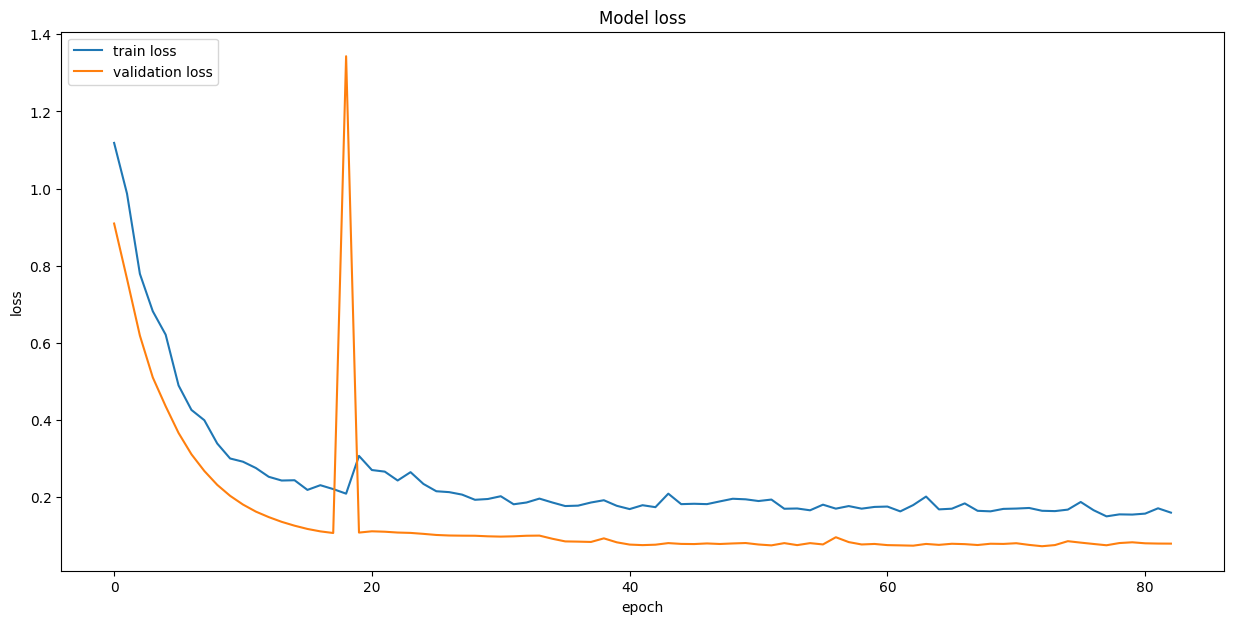

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

Gerando a previsão baseada no modelo criado usando treino e validação para avaliar como será a previsão na base teste.

In [ ]:
data_test = x_scaler.fit_transform(uni_data.tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])
Predicted_results = Trained_model.predict(test_rescaled)
Predicted_results

1/1 [==============================] - 2s 2s/step


array([[1.3798349, 1.3822522, 1.3846242, 1.386976 , 1.38915  , 1.391165 ,
        1.3932173, 1.3950903, 1.396866 , 1.3985856, 1.4002507, 1.4016806,
        1.4031615, 1.4044737, 1.405853 , 1.4071064, 1.4081753, 1.4091444,
        1.41017  , 1.4109517, 1.4116083, 1.4122376, 1.4128503, 1.4132684,
        1.4135373, 1.4136577, 1.4138837, 1.4137915, 1.4134946, 1.4130993,
        1.41265  , 1.4122362, 1.4114809, 1.4106877, 1.409698 , 1.4085244,
        1.4074062, 1.4060824, 1.4046102, 1.4031045, 1.401606 , 1.3999671,
        1.3981334, 1.396376 , 1.3944031, 1.3923805, 1.3903664, 1.3882334,
        1.3859324, 1.3837317, 1.3813307, 1.3788657, 1.3765055, 1.3739862,
        1.3712665, 1.3686838, 1.3659372, 1.3630866, 1.3601663, 1.3571548,
        1.3541195, 1.3508717, 1.3477671, 1.3444045, 1.3409923, 1.3374113,
        1.3338268, 1.3300115, 1.3261507, 1.3222013, 1.3182037, 1.3141421,
        1.3099003, 1.3055191, 1.3012067, 1.2966958, 1.2921377, 1.2875738,
        1.2829344, 1.2782263, 1.273462

Coloando a previsão gerada em ordem de grandeza correta, desnomalizando os dados. Gerando uma tendência baseada na previsão para poder suavisar a previsão.

In [ ]:
df2 = predition_X
df2_cycle,df2_trend = hpfilter(df2["Close"], lamb=1600)
df2["Trend"] = df2_trend
data_pred = x_scaler.fit_transform(df2.tail(hist_window))
pred_rescaled = data_pred.reshape(1, data_pred.shape[0], data_pred.shape[1])
Predicted_results_oficial = Trained_model.predict(pred_rescaled)
Predicted_results_oficial_Inv_trans = y_scaler.inverse_transform(Predicted_results_oficial.reshape(-1,1))
Predicted_results_oficial_Inv_trans = pd.DataFrame(Predicted_results_oficial_Inv_trans, columns=['Trend'], index=index_prev_oficial)
Predicted_results_oficial_Inv_trans_cycle,Predicted_results_oficial_Inv_trans_trend = hpfilter(Predicted_results_oficial_Inv_trans, lamb=1600)
ajuste2 = Predicted_results_oficial_Inv_trans_trend[0]-df_close.tail(h+1)[-1]
Predicted_results_oficial_Inv_trans = Predicted_results_oficial_Inv_trans-ajuste2
Predicted_results_oficial_Inv_trans_trend = Predicted_results_oficial_Inv_trans_trend-ajuste2

1/1 [==============================] - 0s 30ms/step


In [ ]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results.reshape(-1,1))
Predicted_results_Inv_trans = pd.DataFrame(Predicted_results_Inv_trans, columns=['Trend'], index=index_prev)
Predicted_results_Inv_trans_cycle,Predicted_results_Inv_trans_trend = hpfilter(Predicted_results_Inv_trans, lamb=1600)
ajuste = Predicted_results_Inv_trans_trend[0]-df_close.tail(h+1)[0]
Predicted_results_Inv_trans_trend = Predicted_results_Inv_trans_trend-ajuste
Predicted_results_Inv_trans = Predicted_results_Inv_trans-ajuste

In [ ]:
test = pd.DataFrame(df_close.tail(h), columns=['Close'], index=index_prev)

Avaliação do Modelo na base teste.

In [ ]:
resultados = pd.concat([resultados,pd.DataFrame(data=timeseries_evaluation_metrics_func(test,Predicted_results_Inv_trans_trend))],axis=0)

Evaluation metric results:-
MSE is : 0.06450614787684857
MAE is : 0.20009932065904243
RMSE is : 0.2539806053163284
MAPE is : 20.104737712205406
R2 is : -0.3365647964962464



Plotando a previsão.

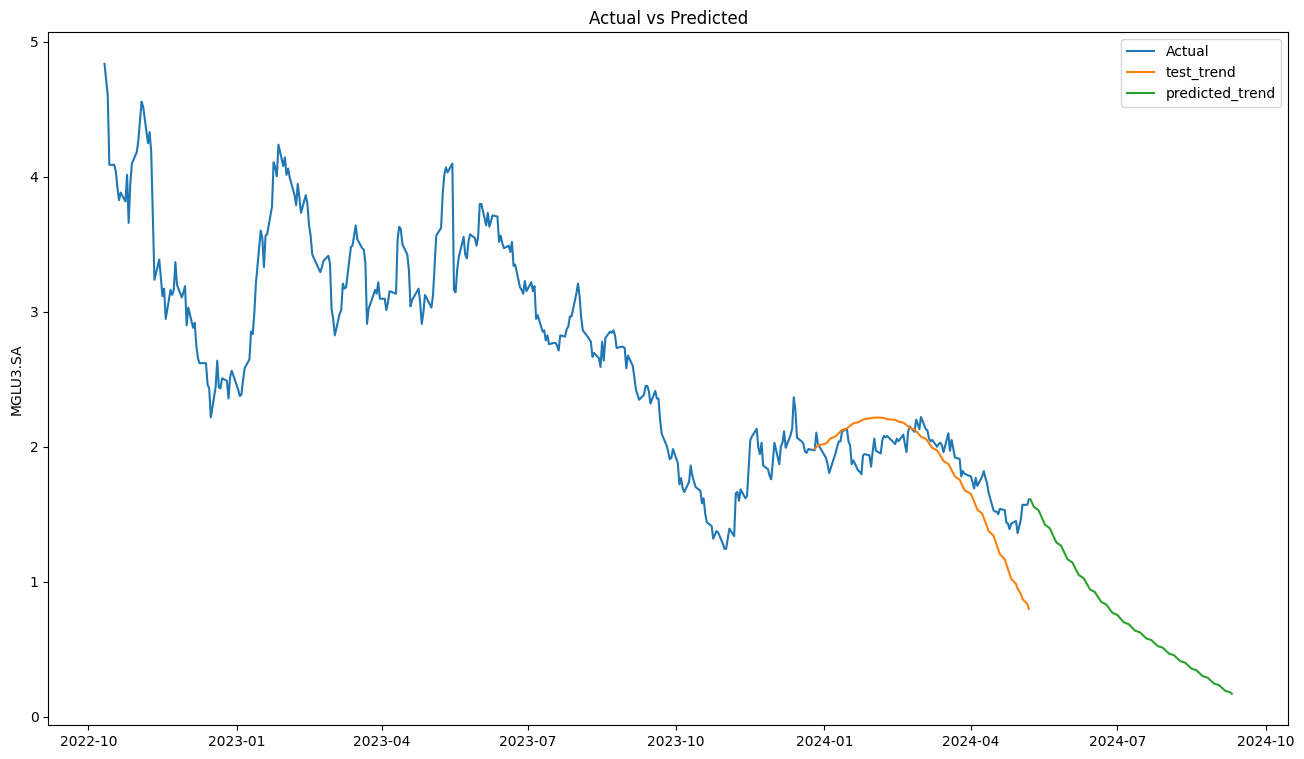

In [ ]:
plt.plot(df_close.tail(h+300))
#plt.plot( Predicted_results_Inv_trans)
#plt.plot( Predicted_results_oficial_Inv_trans)
plt.plot(Predicted_results_Inv_trans_trend)
plt.plot(Predicted_results_oficial_Inv_trans_trend)
plt
plt.title("Actual vs Predicted")
plt.ylabel(f'{asset}')
plt.legend(('Actual','test_trend','predicted_trend'))
plt.show()

# Terceiro modelo - Algoritmo Genético para melhorar ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error
import random
import numpy as np

Dividindo os dados em treino, validação e teste.

In [ ]:
data = df['Close']
train_size = int(len(data) * 0.9)
valid_size = int(len(data) * 0.05)
train, valid, test = data[0:train_size], data[train_size:train_size + valid_size], data[train_size + valid_size:]

Determinando melhores parâmeros para um modelo ARIMA através de Algoritmo Genético

In [ ]:
# Definindo os limites dos parâmetros do modelo ARIMA
p_range = range(0, 30)  # Ordem do componente autoregressivo
d_range = range(0, 3)  # Ordem de diferenciação
q_range = range(0, 30)  # Ordem do componente de média móvel

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_p", random.choice, p_range)
toolbox.register("attr_d", random.choice, d_range)
toolbox.register("attr_q", random.choice, q_range)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_p, toolbox.attr_d, toolbox.attr_q), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    order = (individual[0], individual[1], individual[2])
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        pred = model_fit.forecast(steps=len(valid))
        mse = mean_squared_error(valid, pred)
        return (mse,)
    except:
        return (np.inf,)  # Caso o modelo falhe na convergência

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[0, 0, 0], up=[2, 1, 2], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Configuração do algoritmo genético
population = toolbox.population(n=50)
ngen = 5
cxpb, mutpb = 0.5, 0.2

result, log = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=True)

# Extraindo os melhores parâmetros
best_individual = tools.selBest(population, k=1)[0]
print('Melhores parâmetros ARIMA:', best_individual)
print('Melhor MSE:', evaluate(best_individual))


gen	nevals
0  	50    
1  	35    
2  	28    
3  	31    
4  	29    
5  	21    
Melhores parâmetros ARIMA: [28, 0, 10]
Melhor MSE: (0.014220831129557406,)


Analisando a performance do modelo.

In [ ]:
# Construindo o modelo com os melhores parâmetros
best_order = (best_individual[0], best_individual[1], best_individual[2])
model = ARIMA(np.concatenate((train, valid)), order=best_order)
model_fit = model.fit()

# Previsão no conjunto de teste
predictions = model_fit.forecast(steps=len(test))

resultados = pd.concat([resultados,pd.DataFrame(data=timeseries_evaluation_metrics_func(test,predictions))],axis=0)

Evaluation metric results:-
MSE is : 0.19031327392428038
MAE is : 0.3479057884606748
RMSE is : 0.4362490961873507
MAPE is : 21.67818592927152
R2 is : -1.9648231025841474



Plotando o gráfico.

In [ ]:
pred = pd.DataFrame(predictions, columns=['Close'], index=test.index)

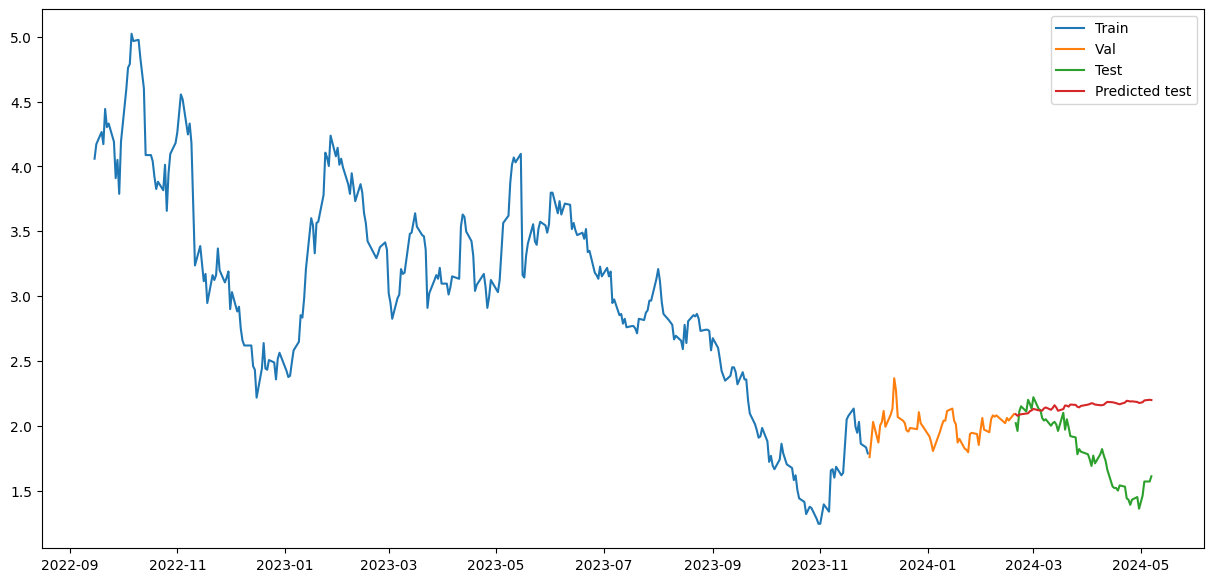

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,7]
plt.plot( train[-300:], label='Train ')
plt.plot( valid, label='Val ')
plt.plot(test, label='Test ')
plt.plot(pred, label='Predicted test')
plt.legend(loc='best')
plt.show()

# Comparação entre os modelos

In [ ]:
index = ["Auto-Arima","LSTM","AG - Arima"]
resultados.index = index
resultados.round(2)


,MSE,MAE,RMSE,MAPE,R2
Auto-Arima,0.15,0.36,0.39,23.38,-5.58
LSTM,0.06,0.20,0.25,20.10,-0.34
AG - Arima,0.19,0.35,0.44,21.68,-1.96
